# Análisis de Matching Idealista ↔ Catastro

**Spike Data Validation - Fase 2**

Este notebook analiza la calidad del matching heurístico entre propiedades de Idealista y edificios de Catastro para el barrio de Gràcia.

## Objetivos

1. Evaluar la calidad de los matches obtenidos
2. Analizar la distribución de scores de matching
3. Validar la completitud de los datos combinados
4. Identificar oportunidades de mejora
5. Documentar los resultados para el modelo hedónico MICRO


In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configuración
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Rutas
DATA_DIR = Path("../data/processed/fase2")
MATCHED_CSV = DATA_DIR / "idealista_catastro_matched.csv"
METRICS_JSON = DATA_DIR / "idealista_catastro_matched_metrics.json"

print("✅ Librerías cargadas")


✅ Librerías cargadas


## 1. Carga de Datos


In [3]:
# Cargar datos
df = pd.read_csv(MATCHED_CSV)
with open(METRICS_JSON, 'r', encoding='utf-8') as f:
    metrics = json.load(f)

print(f"📊 Total propiedades Idealista: {len(df)}")
print(f"📊 Total columnas: {len(df.columns)}")
print(f"\nColumnas disponibles:")
for col in df.columns:
    print(f"  - {col}")


📊 Total propiedades Idealista: 299
📊 Total columnas: 19

Columnas disponibles:
  - precio
  - superficie_m2
  - habitaciones
  - banos
  - localidad
  - link
  - descripcion
  - detalles
  - match_score
  - matched
  - catastro_referencia_catastral
  - catastro_direccion_normalizada
  - catastro_ano_construccion
  - catastro_plantas
  - catastro_lat
  - catastro_lon
  - catastro_direccion
  - catastro_barrio_id
  - catastro_barrio_nombre


## 2. Métricas Generales de Matching


In [4]:
# Separar matches y no matches
matched = df[df['match_score'] >= 0.5].copy()
unmatched = df[df['match_score'] < 0.5].copy()

print("=" * 70)
print("MÉTRICAS GENERALES DE MATCHING")
print("=" * 70)
print(f"\nTotal propiedades Idealista: {len(df)}")
print(f"Matches exitosos (score >= 0.5): {len(matched)} ({len(matched)/len(df)*100:.1f}%)")
print(f"Sin match (score < 0.5): {len(unmatched)} ({len(unmatched)/len(df)*100:.1f}%)")
print(f"\nScore promedio de matches: {matched['match_score'].mean():.3f}")
print(f"Score mediano: {matched['match_score'].median():.3f}")
print(f"Score mínimo: {matched['match_score'].min():.3f}")
print(f"Score máximo: {matched['match_score'].max():.3f}")


MÉTRICAS GENERALES DE MATCHING

Total propiedades Idealista: 299
Matches exitosos (score >= 0.5): 140 (46.8%)
Sin match (score < 0.5): 159 (53.2%)

Score promedio de matches: 0.613
Score mediano: 0.600
Score mínimo: 0.501
Score máximo: 0.700


## 3. Distribución de Scores


Distribución de scores por rangos:
  0.50-0.55:  26 propiedades ( 18.6%)
  0.55-0.60:  24 propiedades ( 17.1%)
  0.60-0.65:  46 propiedades ( 32.9%)
  0.65-0.70:  18 propiedades ( 12.9%)
  0.70+:  26 propiedades ( 18.6%)


/var/folders/8t/1rzjlj6n3rj3v08skl2pwjbm0000gn/T/ipykernel_15450/1248556125.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(data_to_plot, labels=['Matched', 'Unmatched'], patch_artist=True)


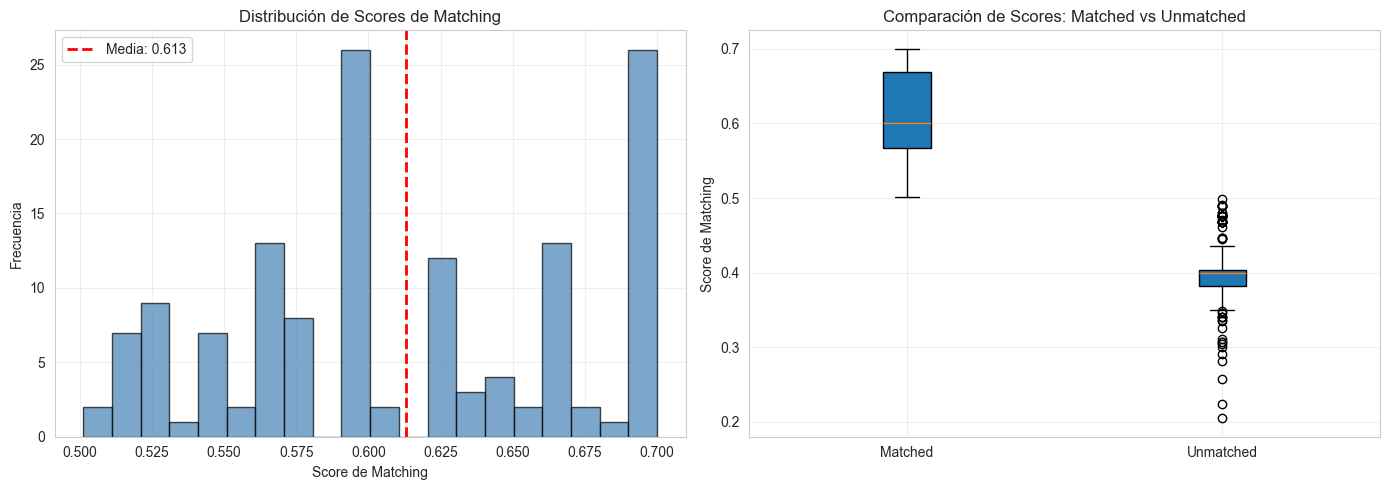

In [5]:
# Distribución por rangos
score_ranges = [
    (0.5, 0.55, '0.50-0.55'),
    (0.55, 0.60, '0.55-0.60'),
    (0.60, 0.65, '0.60-0.65'),
    (0.65, 0.70, '0.65-0.70'),
    (0.70, 1.0, '0.70+'),
]

print("Distribución de scores por rangos:")
for min_score, max_score, label in score_ranges:
    count = len(matched[(matched['match_score'] >= min_score) & (matched['match_score'] < max_score)])
    pct = (count / len(matched) * 100) if len(matched) > 0 else 0
    print(f"  {label}: {count:3d} propiedades ({pct:5.1f}%)")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma de scores
axes[0].hist(matched['match_score'], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(matched['match_score'].mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {matched["match_score"].mean():.3f}')
axes[0].set_xlabel('Score de Matching')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Scores de Matching')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot comparativo
if len(unmatched) > 0:
    data_to_plot = [matched['match_score'], unmatched['match_score']]
    axes[1].boxplot(data_to_plot, labels=['Matched', 'Unmatched'], patch_artist=True)
    axes[1].set_ylabel('Score de Matching')
    axes[1].set_title('Comparación de Scores: Matched vs Unmatched')
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 4. Completitud de Datos en Matches


Completitud de datos de Catastro en matches:
Año Construcción              : 140/140 (100.0%)
Plantas                       : 115/140 ( 82.1%)
Coordenadas (lat)             : 140/140 (100.0%)
Coordenadas (lon)             : 140/140 (100.0%)
Barrio                        : 140/140 (100.0%)
Referencia Catastral          : 140/140 (100.0%)
Dirección                     : 140/140 (100.0%)


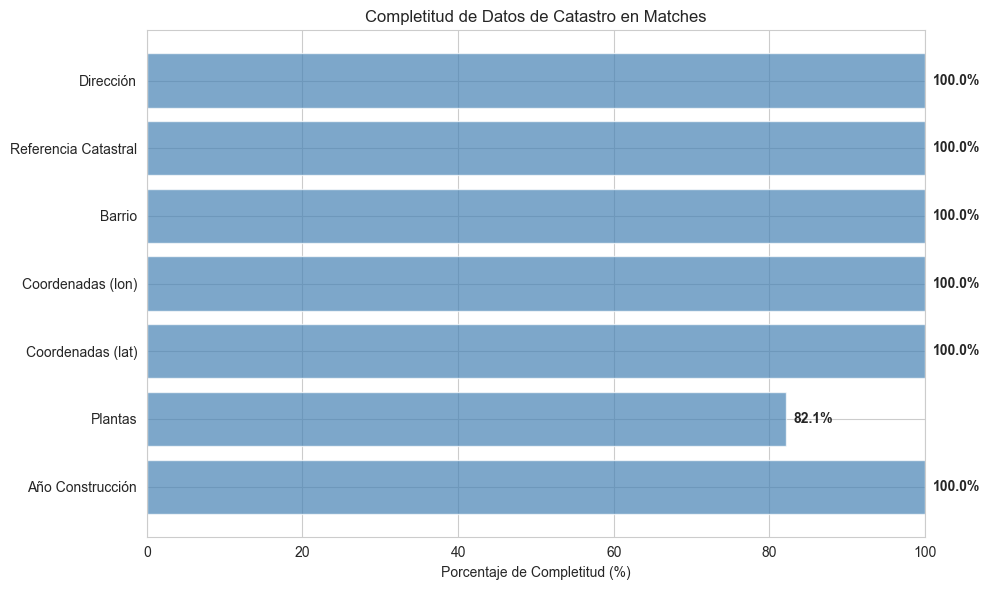

In [6]:
# Analizar completitud de datos de Catastro en matches
completitud = {
    'Año Construcción': matched['catastro_ano_construccion'].notna().sum(),
    'Plantas': matched['catastro_plantas'].notna().sum(),
    'Coordenadas (lat)': matched['catastro_lat'].notna().sum(),
    'Coordenadas (lon)': matched['catastro_lon'].notna().sum(),
    'Barrio': matched['catastro_barrio_nombre'].notna().sum(),
    'Referencia Catastral': matched['catastro_referencia_catastral'].notna().sum(),
    'Dirección': matched['catastro_direccion'].notna().sum(),
}

print("Completitud de datos de Catastro en matches:")
print("=" * 70)
for campo, count in completitud.items():
    pct = (count / len(matched) * 100) if len(matched) > 0 else 0
    print(f"{campo:30s}: {count:3d}/{len(matched)} ({pct:5.1f}%)")

# Visualización
fig, ax = plt.subplots(figsize=(10, 6))
campos = list(completitud.keys())
valores = [completitud[c] / len(matched) * 100 for c in campos]

bars = ax.barh(campos, valores, color='steelblue', alpha=0.7)
ax.set_xlabel('Porcentaje de Completitud (%)')
ax.set_title('Completitud de Datos de Catastro en Matches')
ax.set_xlim(0, 100)

# Añadir valores en las barras
for i, (bar, val) in enumerate(zip(bars, valores)):
    ax.text(val + 1, i, f'{val:.1f}%', va='center', fontweight='bold')

plt.tight_layout()
plt.show()


## 5. Análisis por Barrio


Matches por Barrio:
                                    Count  Score_Promedio  Precio_Promedio  Superficie_Promedio
catastro_barrio_nombre                                                                         
el Camp d'en Grassot i Gràcia Nova     49            0.65        518448.98                89.33
la Vila de Gràcia                      40            0.57        533125.00                80.03
la Salut                               28            0.62        490928.57                98.18
Vallcarca i els Penitents              14            0.64        632785.71               108.79
el Coll                                 9            0.56        495544.44               137.44


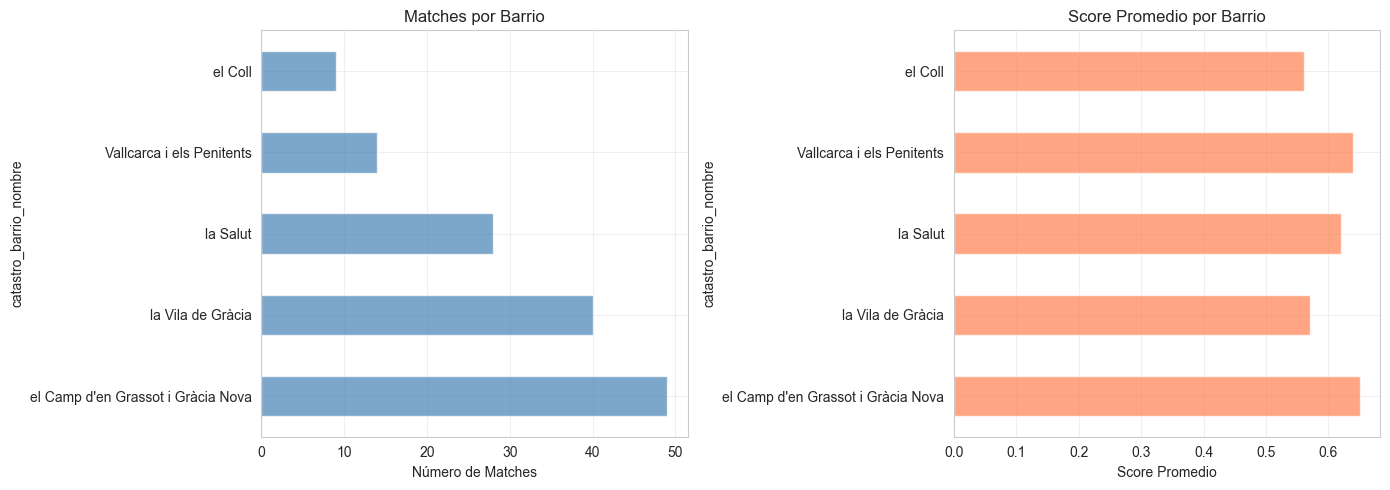

In [7]:
# Análisis de matches por barrio
if 'catastro_barrio_nombre' in matched.columns:
    matches_por_barrio = matched.groupby('catastro_barrio_nombre').agg({
        'match_score': ['count', 'mean'],
        'precio': 'mean',
        'superficie_m2': 'mean',
    }).round(2)
    
    matches_por_barrio.columns = ['Count', 'Score_Promedio', 'Precio_Promedio', 'Superficie_Promedio']
    matches_por_barrio = matches_por_barrio.sort_values('Count', ascending=False)
    
    print("Matches por Barrio:")
    print("=" * 70)
    print(matches_por_barrio.to_string())
    
    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Count por barrio
    matches_por_barrio['Count'].plot(kind='barh', ax=axes[0], color='steelblue', alpha=0.7)
    axes[0].set_xlabel('Número de Matches')
    axes[0].set_title('Matches por Barrio')
    axes[0].grid(True, alpha=0.3)
    
    # Score promedio por barrio
    matches_por_barrio['Score_Promedio'].plot(kind='barh', ax=axes[1], color='coral', alpha=0.7)
    axes[1].set_xlabel('Score Promedio')
    axes[1].set_title('Score Promedio por Barrio')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No hay información de barrio disponible")


## 6. Análisis de Propiedades Sin Match


In [8]:
# Analizar propiedades sin match
if len(unmatched) > 0:
    print(f"Propiedades sin match: {len(unmatched)}")
    print(f"Score promedio: {unmatched['match_score'].mean():.3f}")
    print(f"Score máximo: {unmatched['match_score'].max():.3f}")
    print(f"Score mínimo: {unmatched['match_score'].min():.3f}")
    
    # Razones probables
    print("\nRazones probables de no match:")
    print("  1. Diferencias en nombres de barrios/localidades")
    print("  2. Diferencias en superficies (>15% tolerancia)")
    print("  3. Propiedades fuera del área cubierta por Catastro")
    print("  4. Datos incompletos en Idealista o Catastro")
    
    # Análisis de localidades sin match
    if 'localidad' in unmatched.columns:
        localidades_unmatched = unmatched['localidad'].value_counts().head(10)
        print("\nTop 10 localidades sin match:")
        for loc, count in localidades_unmatched.items():
            print(f"  {loc}: {count}")
else:
    print("✅ Todas las propiedades tienen match")


Propiedades sin match: 159
Score promedio: 0.401
Score máximo: 0.499
Score mínimo: 0.205

Razones probables de no match:
  1. Diferencias en nombres de barrios/localidades
  2. Diferencias en superficies (>15% tolerancia)
  3. Propiedades fuera del área cubierta por Catastro
  4. Datos incompletos en Idealista o Catastro

Top 10 localidades sin match:
  Vila de Gràcia: 39
  Gràcia, Barcelona: 12
  Barcelona: 9
  El Coll: 5
  Vallcarca i els Penitents: 3
  Corazón de Barcelona: 3
  Travessera de Gràcia, junto a calle Sicília: 3
  Corazón de Gràcia: 3
  Vallcarca, Gràcia: 3
  La Salut: 2


## 7. Resumen y Conclusiones


In [9]:
print("=" * 70)
print("RESUMEN DEL ANÁLISIS DE MATCHING")
print("=" * 70)
print(f"\n✅ Total propiedades Idealista: {len(df)}")
print(f"✅ Matches exitosos: {len(matched)} ({len(matched)/len(df)*100:.1f}%)")
print(f"✅ Score promedio: {matched['match_score'].mean():.3f}")
print(f"✅ Propiedades listas para modelo MICRO: {len(matched)}")
print(f"\n📊 Datos disponibles en matches:")
print(f"   - Año construcción: {matched['catastro_ano_construccion'].notna().sum()}/{len(matched)}")
print(f"   - Plantas: {matched['catastro_plantas'].notna().sum()}/{len(matched)}")
print(f"   - Coordenadas: {matched['catastro_lat'].notna().sum()}/{len(matched)}")
print(f"   - Barrio: {matched['catastro_barrio_nombre'].notna().sum()}/{len(matched)}")
print(f"\n💡 Recomendaciones:")
print(f"   1. Usar los {len(matched)} matches para entrenar el modelo hedónico MICRO")
print(f"   2. Considerar reducir el umbral de score si se necesitan más datos")
print(f"   3. Validar manualmente una muestra de matches para verificar calidad")
print(f"   4. Analizar propiedades sin match para identificar patrones")


RESUMEN DEL ANÁLISIS DE MATCHING

✅ Total propiedades Idealista: 299
✅ Matches exitosos: 140 (46.8%)
✅ Score promedio: 0.613
✅ Propiedades listas para modelo MICRO: 140

📊 Datos disponibles en matches:
   - Año construcción: 140/140
   - Plantas: 115/140
   - Coordenadas: 140/140
   - Barrio: 140/140

💡 Recomendaciones:
   1. Usar los 140 matches para entrenar el modelo hedónico MICRO
   2. Considerar reducir el umbral de score si se necesitan más datos
   3. Validar manualmente una muestra de matches para verificar calidad
   4. Analizar propiedades sin match para identificar patrones
